# AI-PBPK model project: hyperparameters tuning with BayesSearchCV
Author: Kun Mi
Date created: 2025/05/07

Description: In this study, we used ML and Deep nerual network models to predict the require parameter which can be inputed into the PBPK model  


# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]
!pip install -q keras-tuner
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.4 MB/s eta 0:00:00


In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/2-AI-PBPK"

# choose where you want your project files to be saved
project_folder = "/Final model/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-1.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

,0
Ori,152
ID,0
Type,0
TS,0
MAT,0
Size,46
Zeta,71
Charge,66
Shape,0
TM,0


In [ ]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
df = pd.DataFrame(Data)
q_high=df["KTRES50"].quantile(0.975)
q_low=df["KTRES50"].quantile(0.025)
df_filtered=df[(df["KTRES50"]<q_high)&(df["KTRES50"]>q_low)]
df_X = df_filtered[["Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_filtered[["KTRES50"]]

In [ ]:
#Define the variable type
cols_num = ['Size','Zeta','TSz'] #Numerical value
cols_label = ["Type",'TS','Charge','Shape','TM','CT','MAT'] # Label value

# 3. One-hot Encoding



In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_Hybrid  Type_Inorganic  Type_Organic  TS_Active  TS_Passive  \
0            0.0             1.0           0.0        1.0         0.0   
1            0.0             1.0           0.0        0.0         1.0   
2            0.0             1.0           0.0        1.0         0.0   
3            0.0             1.0           0.0        0.0         1.0   
4            0.0             1.0           0.0        1.0         0.0   
..           ...             ...           ...        ...         ...   
393          0.0             0.0           1.0        1.0         0.0   
394          0.0             0.0           1.0        1.0         0.0   
395          1.0             0.0           0.0        1.0         0.0   
396          0.0             0.0           1.0        0.0         1.0   
397          0.0             0.0           1.0        0.0         1.0   

     Charge_Negative  Charge_Neutral  Charge_Positive  Shape_Others  \
0                0.0             1.0              0.

# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size      Zeta       TSz
0    0.090220  0.440698  0.176214
1    0.081726  0.440698  0.176214
2    0.150826  0.409178  0.036715
3    0.374885  0.433368  0.255823
4    0.396924  0.440698  0.255823
..        ...       ...       ...
393  0.360652  0.396863  0.018950
394  0.365243  0.398475  0.018950
395  0.223370  0.375443  0.131465
396  0.039715  0.475150  0.018950
397  0.382002  0.351268  0.013028

[398 rows x 3 columns]


# Compile data

In [ ]:
preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)
print(preData)

         Size      Zeta       TSz  Type_Hybrid  Type_Inorganic  Type_Organic  \
0    0.090220  0.440698  0.176214          0.0             1.0           0.0   
1    0.081726  0.440698  0.176214          0.0             1.0           0.0   
2    0.150826  0.409178  0.036715          0.0             1.0           0.0   
3    0.374885  0.433368  0.255823          0.0             1.0           0.0   
4    0.396924  0.440698  0.255823          0.0             1.0           0.0   
..        ...       ...       ...          ...             ...           ...   
393  0.360652  0.396863  0.018950          0.0             0.0           1.0   
394  0.365243  0.398475  0.018950          0.0             0.0           1.0   
395  0.223370  0.375443  0.131465          1.0             0.0           0.0   
396  0.039715  0.475150  0.018950          0.0             0.0           1.0   
397  0.382002  0.351268  0.013028          0.0             0.0           1.0   

     TS_Active  TS_Passive  Charge_Nega

# Define X and y

In [ ]:
y_re = df_y
X_re = preData

#Data split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=6)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(318, 42) (80, 42) (318, 1) (80, 1)


In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox', standardize=True)
y_train_bc = pt.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_bc  = pt.transform(y_test.values.reshape(-1, 1)).ravel()

# LightGbm model with pretest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.kernel_ridge import KernelRidge

###Kernel Ridge

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#KernelRidge
def objective(trial):
    param = {
    "kernel": trial.suggest_categorical("kernel", ["rbf"]),
    "alpha": trial.suggest_loguniform("alpha", 1e-3, 1e0),
    "gamma": trial.suggest_loguniform("gamma", 1e-4, 1e-1),
    }

    model = KernelRidge(**param)

    model.fit(X_train, y_train_bc)

    preds_bc = model.predict(X_test)
    preds = pt.inverse_transform(preds_bc.reshape(-1, 1)).ravel()
    Score = r2_score(y_test, preds)

    return Score


# Optimization
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

Best parameters: {'kernel': 'rbf', 'alpha': 0.04911512600410819, 'gamma': 0.031670278658684006}
Best R² score: 0.0308


In [ ]:
### Develop the best model
best_params = study.best_params
KRR = KernelRidge(**best_params)

KRR.fit(X_train, y_train_bc)

train_preds_bc = KRR.predict(X_train)
test_preds_bc = KRR.predict(X_test)

train_preds = pt.inverse_transform(train_preds_bc.reshape(-1, 1)).ravel()
test_preds = pt.inverse_transform(test_preds_bc.reshape(-1, 1)).ravel()

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Predict on the test set
# Define KFold for cross-validation

cv = KFold(n_splits=5, shuffle=True, random_state=3407)
r2_list, rmse_list = [], []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_bc, y_val_bc  = y_train_bc[train_idx], y_train_bc[val_idx]

    model = KernelRidge(**best_params)
    model.fit(X_tr, y_tr_bc)

    val_preds_bc = model.predict(X_val)

    val_preds = pt.inverse_transform(val_preds_bc.reshape(-1, 1)).ravel()
    y_val = pt.inverse_transform(y_val_bc.reshape(-1, 1)).ravel()

    r2 = r2_score(y_val, val_preds)
    rmse = root_mean_squared_error(y_val, val_preds)

    r2_list.append(r2)
    rmse_list.append(rmse)

print("\nCross-Validation Performance (original scale):")
print(f"R2 Score : {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
print(f"RMSE     : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")

Trian set r2 0.12222213034571605
Trian set RMSE 27.08060630249447
---------------------------------------------------------------------
Test set r2 0.03083084844260564
Test set RMSE 27.68122875740125

Cross-Validation Performance (original scale):
R2 Score : -0.180 ± 0.063
RMSE     : 31.360 ± 1.354


###Random forest

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
optuna.logging.set_verbosity(optuna.logging.ERROR)

#Random forest model
def objective(trial):
    param = {"n_estimators": trial.suggest_int("n_estimators", 100, 500),
        # "max_depth": trial.suggest_int("max_depth", 3, 10),
        # "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])}

    model = RandomForestRegressor(**param)

    model.fit(X_train, y_train_bc)

    preds_bc = model.predict(X_test)
    preds = pt.inverse_transform(preds_bc.reshape(-1, 1)).ravel()

    Score = r2_score(y_test, preds)

    return Score

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 200)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)


Best parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'bootstrap': False}
Best r2 score: 0.11286323160541467


In [ ]:
### Develop the best model
best_params = study.best_params
rf = RandomForestRegressor(**best_params)

rf.fit(X_train, y_train_bc)

train_preds_bc = rf.predict(X_train)
test_preds_bc = rf.predict(X_test)

train_preds = pt.inverse_transform(train_preds_bc.reshape(-1, 1)).ravel()
test_preds = pt.inverse_transform(test_preds_bc.reshape(-1, 1)).ravel()

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Predict on the test set
# Define KFold for cross-validation

cv = KFold(n_splits=5, shuffle=True, random_state=7)
r2_list, rmse_list = [], []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_bc, y_val_bc  = y_train_bc[train_idx], y_train_bc[val_idx]

    model = RandomForestRegressor(**best_params)
    model.fit(X_tr, y_tr_bc)

    val_preds_bc = model.predict(X_val)

    val_preds = pt.inverse_transform(val_preds_bc.reshape(-1, 1)).ravel()
    y_val = pt.inverse_transform(y_val_bc.reshape(-1, 1)).ravel()

    r2 = r2_score(y_val, val_preds)
    rmse = root_mean_squared_error(y_val, val_preds)

    r2_list.append(r2)
    rmse_list.append(rmse)

print("\nCross-Validation Performance (original scale):")
print(f"R2 Score : {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
print(f"RMSE     : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")

Trian set r2 0.9682603004099972
Trian set RMSE 5.149528614795028
---------------------------------------------------------------------
Test set r2 0.06861292420962217
Test set RMSE 27.13630281275669

Cross-Validation Performance (original scale):
R2 Score : 0.024 ± 0.160
RMSE     : 28.313 ± 3.181


##XGBoost

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        # "gamma": trial.suggest_loguniform("gamma", 1e-2, 1),
        # "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        # "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0)
    }

    model = XGBRegressor(**param, random_state=42)

    model.fit(X_train, y_train_bc)

    preds_bc = model.predict(X_test)
    preds = pt.inverse_transform(preds_bc.reshape(-1, 1)).ravel()

    Score = r2_score(y_test, preds)

    return Score



# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'n_estimators': 157, 'max_depth': 8, 'learning_rate': 0.19027796161090385}
Best r2 score: 0.1920197606086731


In [ ]:
### Develop the best model
best_params = study.best_params
XGB= XGBRegressor(**best_params, random_state=42)
XGB.fit(X_train, y_train_bc)

train_preds_bc = XGB.predict(X_train)
test_preds_bc = XGB.predict(X_test)

train_preds = pt.inverse_transform(train_preds_bc.reshape(-1, 1)).ravel()
test_preds = pt.inverse_transform(test_preds_bc.reshape(-1, 1)).ravel()

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# Predict on the test set
# Define KFold for cross-validation

cv = KFold(n_splits=5, shuffle=True, random_state=27)
r2_list, rmse_list = [], []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_bc, y_val_bc  = y_train_bc[train_idx], y_train_bc[val_idx]

    model = XGBRegressor(**best_params)
    model.fit(X_tr, y_tr_bc)

    val_preds_bc = model.predict(X_val)

    val_preds = pt.inverse_transform(val_preds_bc.reshape(-1, 1)).ravel()
    y_val = pt.inverse_transform(y_val_bc.reshape(-1, 1)).ravel()

    r2 = r2_score(y_val, val_preds)
    rmse = root_mean_squared_error(y_val, val_preds)

    r2_list.append(r2)
    rmse_list.append(rmse)

print("\nCross-Validation Performance (original scale):")
print(f"R2 Score : {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
print(f"RMSE     : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")

Trian set r2 0.9682502746582031
Trian set RMSE 5.150341510772705
---------------------------------------------------------------------
Test set r2 0.1920197606086731
Test set RMSE 25.274696350097656

Cross-Validation Performance (original scale):
R2 Score : 0.014 ± 0.272
RMSE     : 28.387 ± 5.187


## SVM

In [ ]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e3),
        "epsilon": trial.suggest_uniform("epsilon", 0.01, 1.0),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5),
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "coef0": trial.suggest_uniform("coef0", 0.0, 1.0)
    }

    model = SVR(**param)


    if np.isnan(X_train).any().any() or np.isnan(y_train_bc).any():
        raise ValueError("Training data contains NaN")

    model.fit(X_train, y_train_bc)

    preds_bc = model.predict(X_test).reshape(-1, 1)
    preds = pt.inverse_transform(preds_bc).ravel()

    if np.isnan(preds).any():
        return -np.inf

    score = r2_score(y_test, preds)
    return score



# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'C': 102.3704723151311, 'epsilon': 0.41120981592709427, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.1062635755817722, 'coef0': 0.34618045504894535}
Best r2 score: 0.10304472459505942


In [ ]:
### Develop the best model
from sklearn.svm import SVR

best_params = study.best_params
SVR= SVR(**best_params)
SVR.fit(X_train, y_train_bc)

train_preds_bc = SVR.predict(X_train)
test_preds_bc = SVR.predict(X_test)

train_preds = pt.inverse_transform(train_preds_bc.reshape(-1, 1)).ravel()
test_preds = pt.inverse_transform(test_preds_bc.reshape(-1, 1)).ravel()

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))



Trian set r2 0.40374381620053534
Trian set RMSE 22.31940012114123
---------------------------------------------------------------------
Test set r2 0.10304472459505942
Test set RMSE 26.62998780185648


In [ ]:
from sklearn.svm import SVR

# Predict on the test set
# Define KFold for cross-validation

cv = KFold(n_splits=5, shuffle=True, random_state=27)
r2_list, rmse_list = [], []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_bc, y_val_bc  = y_train_bc[train_idx], y_train_bc[val_idx]

    model = SVR(**best_params)
    model.fit(X_tr, y_tr_bc)

    val_preds_bc = model.predict(X_val)

    val_preds = pt.inverse_transform(val_preds_bc.reshape(-1, 1)).ravel()
    y_val = pt.inverse_transform(y_val_bc.reshape(-1, 1)).ravel()

    r2 = r2_score(y_val, val_preds)
    rmse = root_mean_squared_error(y_val, val_preds)

    r2_list.append(r2)
    rmse_list.append(rmse)

print("\nCross-Validation Performance (original scale):")
print(f"R2 Score : {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")
print(f"RMSE     : {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")



Cross-Validation Performance (original scale):
R2 Score : -0.126 ± 0.172
RMSE     : 30.536 ± 3.802


# Deep nerual network model with keras

In [ ]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
import optuna
# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.layers import BatchNormalization

In [ ]:
X = X_re.to_numpy()
y = y_re.to_numpy()
# summarize shape
print(X.shape, y.shape)

(398, 42) (398, 1)


In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=6)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.125, random_state=6)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(X_temp.shape, X_test.shape, y_temp.shape, y_test.shape)

# y_train_log=np.log1p(y_train)
# y_val_log=np.log1p(y_val)
# y_test_log=np.log1p(y_test)

(278, 42) (40, 42) (278, 1) (40, 1)
(318, 42) (80, 42) (318, 1) (80, 1)


In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='box-cox', standardize=True)
y_train_bc = pt.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_bc   = pt.transform(y_val.reshape(-1,1)).ravel()
y_test_bc  = pt.transform(y_test.reshape(-1,1)).ravel()
y_temp_bc  = pt.transform(y_temp.reshape(-1,1)).ravel()

# Tuning Model with Keras Tuner

In [ ]:
!pip install -q optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score
from optuna.integration import TFKerasPruningCallback
import tempfile
import os

def objective(trial):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    # Input
    dense_bot = trial.suggest_int('dense_bot', 42, 522, step=16)
    activation = trial.suggest_categorical('dense_activation', ['relu', 'tanh', 'sigmoid'])
    model.add(Dense(dense_bot, activation=activation))

    # Hidden
    num_layers = trial.suggest_int('num_dense_layers', 1, 5)
    for i in range(num_layers):
        units = trial.suggest_int(f'dense_{i}', 32, 1024, step=32)
        act = trial.suggest_categorical(f'act_{i}', ['relu', 'tanh', 'sigmoid'])
        dropout = trial.suggest_float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        model.add(Dense(units=units, activation=act))
        model.add(Dropout(dropout))
        # model.add(BatchNormalization())

    # Output
    model.add(Dense(1, activation='linear'))
    # Optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Nadam'])
    lr = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    #MSE
    model.compile(
        optimizer=optimizer,
        loss= MeanSquaredError()
    )

    # Model train
    model.fit(X_train, y_train_bc,
         validation_data=(X_val, y_val_bc),
         batch_size=16, epochs=100, verbose=0,
         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
              TFKerasPruningCallback(trial, 'val_loss')])

    # R²
    y_pred_bc = model.predict(X_test, verbose=0)
    y_pred    = pt.inverse_transform(y_pred_bc.reshape(-1,1)).ravel()
    r2 = r2_score(y_test, y_pred)

    # save
    model_path = tempfile.NamedTemporaryFile(delete=False, suffix=".keras").name
    model.save(model_path)

    # save the model
    trial.set_user_attr("model_path", model_path)

    return r2

In [ ]:
from optuna.pruners import MedianPruner

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=12)
)
study.optimize(objective, n_trials=100)

[I 2025-06-25 20:45:42,435] A new study created in memory with name: no-name-8820b053-36ba-4327-bde9-84959b96e9dd
[I 2025-06-25 20:45:54,323] Trial 0 finished with value: -0.3786916680768726 and parameters: {'dense_bot': 186, 'dense_activation': 'tanh', 'num_dense_layers': 4, 'dense_0': 672, 'act_0': 'relu', 'dropout_0': 0.4, 'dense_1': 640, 'act_1': 'sigmoid', 'dropout_1': 0.30000000000000004, 'dense_2': 864, 'act_2': 'tanh', 'dropout_2': 0.4, 'dense_3': 256, 'act_3': 'tanh', 'dropout_3': 0.4, 'optimizer': 'Adam', 'learning_rate': 0.0001}. Best is trial 0 with value: -0.3786916680768726.
[I 2025-06-25 20:45:58,548] Trial 1 finished with value: -0.4299547851525485 and parameters: {'dense_bot': 154, 'dense_activation': 'sigmoid', 'num_dense_layers': 1, 'dense_0': 448, 'act_0': 'tanh', 'dropout_0': 0.0, 'optimizer': 'Adam', 'learning_rate': 1e-05}. Best is trial 0 with value: -0.3786916680768726.
[I 2025-06-25 20:46:34,396] Trial 2 finished with value: -0.25740902903186735 and parameters

In [ ]:
# Load model
best_model_path = study.best_trial.user_attrs["model_path"]
best_model = tf.keras.models.load_model(best_model_path)

# Model prediction
y_temp_bc= best_model.predict(X_temp)
y_test_bc = best_model.predict(X_test)

y_temp_pred   = pt.inverse_transform(y_temp_bc.reshape(-1,1)).ravel()
y_test_pred   = pt.inverse_transform(y_test_bc.reshape(-1,1)).ravel()

print("Best train R²:",r2_score(y_temp, y_temp_pred))
print("Best train rmse:",root_mean_squared_error(y_temp, y_temp_pred))
print("Best test R²:",r2_score(y_test, y_test_pred))
print("Best test rmse:",root_mean_squared_error(y_test, y_test_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Best train R²: 0.522987813745756
Best train rmse: 19.96322983834488
Best test R²: 0.27588850639186246
Best test rmse: 23.92700243233703


In [ ]:
def build_best_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input
    model.add(Dense(params['dense_bot'], activation=params['dense_activation']))

    # Hidden
    for i in range(params['num_dense_layers']):
        model.add(Dense(params[f'dense_{i}'], activation=params[f'act_{i}']))
        model.add(Dropout(params[f'dropout_{i}']))
        model.add(BatchNormalization())

    # Output
    model.add(Dense(1, activation='linear'))

    # Optimizer
    if params['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='mse',metrics= ['mae','mse'])
    return model


In [ ]:
params = study.best_trial.params
model = build_best_model(params)

In [ ]:
# save model and architecture to single file
best_model.save("KTRES50_0620-3.keras")
print("Saved model to disk")

Saved model to disk


In [ ]:
load_model= keras.models.load_model("KTRES50_0515-5.keras")

In [ ]:
load_model= keras.models.load_model("KTRES50_0620-3.keras")

#seed 31 to 3,4,5,6

best_model= load_model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model.fit(X_train, y_train_bc,
        validation_data=(X_val, y_val_bc),
        batch_size=32,
        epochs=128,
        verbose=0,
        callbacks=[early_stop]
               )

# Model prediction
y_temp_bc= best_model.predict(X_temp)
y_test_bc = best_model.predict(X_test)

y_temp_pred   = pt.inverse_transform(y_temp_bc.reshape(-1,1)).ravel()
y_test_pred   = pt.inverse_transform(y_test_bc.reshape(-1,1)).ravel()

print("Best train R²:",r2_score(y_temp, y_temp_pred))
print("Best train rmse:",root_mean_squared_error(y_temp, y_temp_pred))
print("Best test R²:",r2_score(y_test, y_test_pred))
print("Best test rmse:",root_mean_squared_error(y_test, y_test_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Best train R²: 0.5850289686167952
Best train rmse: 18.619797775028072
Best test R²: 0.2967707577455494
Best test rmse: 23.57946972414732


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


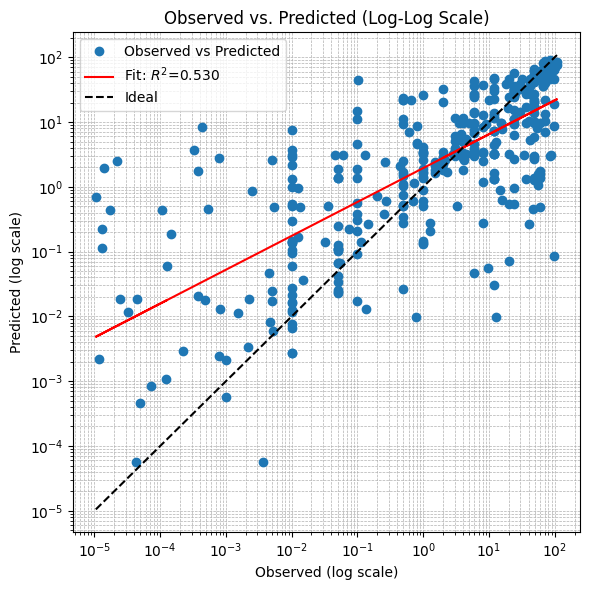

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Model prediction
y_obs = y_re
all_preds_bc = best_model.predict(X_re)
all_preds = pt.inverse_transform(all_preds_bc.reshape(-1, 1)).ravel()

# Flatten
y_obs = np.ravel(y_obs)
all_preds = np.ravel(all_preds)

# log10 for linear fit
log_y_obs = np.log10(y_obs)
log_y_pred = np.log10(all_preds)

# Linear fit
m, b = np.polyfit(log_y_obs, log_y_pred, 1)
fit_line = m * log_y_obs + b

# Calculate R2 in log scale
r2 = r2_score(y_obs, all_preds)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(y_obs, all_preds, 'o', label='Observed vs Predicted')
plt.plot(10**log_y_obs, 10**fit_line, 'r-', label=f'Fit: $R^2$={r2:.3f}')
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'k--', label='Ideal')

# Axis in log scale
plt.xscale("log")
plt.yscale("log")

# Labels and format
plt.xlabel("Observed (log scale)")
plt.ylabel("Predicted (log scale)")
plt.title("Observed vs. Predicted (Log-Log Scale)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
r2_score(y_obs, all_preds)

0.5296679864753853

In [ ]:
PredKmax = pd.concat([pd.DataFrame(df_filtered["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","OBS", "KTRES50"]
PredKmax.to_csv('KTRES50.csv', encoding = 'utf-8-sig',index=False)

##Cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow.keras as keras

dnn_base_model = keras.models.load_model("KTRES50_0620-3.keras")

kfold = KFold(n_splits=5, shuffle=True, random_state=6)
cvr2scores = []
cvrmsescores = []

for fold, (train_ix, test_ix) in enumerate(kfold.split(X_temp), 1):
    X_train_n, X_test_n = X_temp[train_ix], X_temp[test_ix]
    y_train_n, y_test_n = y_temp[train_ix], y_temp[test_ix]

    dnn_model = clone_model(dnn_base_model)
    dnn_model.set_weights(dnn_base_model.get_weights())
    dnn_model.compile(optimizer='Nadam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dnn_model.fit(X_train_n, y_train_n, validation_data=(X_test_n, y_test_n), callbacks=[early_stop],
                  epochs=100, batch_size=32, verbose=0)

    # Prediction and evaluation
    test_pred = dnn_model.predict(X_test_n).flatten()
    r2score = r2_score(y_test_n, test_pred)
    rmse = root_mean_squared_error(y_test_n, test_pred)

    print(f"[Fold {fold}] R²: {r2score:.3f}, RMSE: {rmse:.3f}")

    cvr2scores.append(r2score)
    cvrmsescores.append(rmse)

# Output prediction
print("\n=== Cross-validation summary ===")
print("The 5-CV R² Score was: %.2f (+/- %.2f)" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-CV RMSE Score was: %.2f (+/- %.2f)" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[Fold 1] R²: 0.397, RMSE: 22.844
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[Fold 2] R²: 0.468, RMSE: 18.676
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[Fold 3] R²: 0.605, RMSE: 20.322


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[Fold 4] R²: 0.345, RMSE: 22.332
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
[Fold 5] R²: 0.535, RMSE: 19.762

=== Cross-validation summary ===
The 5-CV R² Score was: 0.47 (+/- 0.09)
The 5-CV RMSE Score was: 20.79 (+/- 1.57)


#Make the predictions

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-prediction-1.csv"))
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column
df = pd.DataFrame(Data)

df_ori =df.iloc[0:-2]

q_high=df_ori["KTRES50"].quantile(0.975)
q_low=df_ori["KTRES50"].quantile(0.025)
df_filtered=df_ori[(df_ori["KTRES50"]<q_high)&(df_ori["KTRES50"]>q_low)]

df_merge = pd.concat([df_filtered, df.iloc[-2:]], axis=0)


df_X = df_merge[["ID","Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_merge[["KTRES50"]]

test_X = df_X

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)

preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)

y_re = df_y
X_re = preData


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

X = X_re.iloc[0:-2].to_numpy()
y = y_re.iloc[0:-2].to_numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=6)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.125, random_state=6)


pt = PowerTransformer(method='box-cox', standardize=True)
y_train_bc = pt.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_bc   = pt.transform(y_val.reshape(-1,1)).ravel()
y_test_bc  = pt.transform(y_test.reshape(-1,1)).ravel()
y_temp_bc  = pt.transform(y_temp.reshape(-1,1)).ravel()

In [ ]:
best_model= keras.models.load_model("KTRES50_0620-3.keras")
all_preds_bc = best_model.predict(X_re.iloc[-2:].to_numpy())
all_preds = pt.inverse_transform(all_preds_bc.reshape(-1, 1)).ravel()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


In [ ]:
all_preds

array([0.4366054 , 0.10217334], dtype=float32)